# 2021/10/13
The jupypter notebook is used to load the model after GridSearch


In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [33]:
import pandas as pd
import numpy as np
import sys, os

## Load the model

In [9]:
import joblib
input_path='/pod/2/li-lab/Ziwei/Nanopore/daily/2021-10-11'
pkl = 'rf_smote_gridsearch.pkl'
rf_model = joblib.load(os.path.join(input_path, pkl))
rf_model

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rfr',
                 RandomForestClassifier(bootstrap=False, max_depth=25,
                                        min_samples_leaf=2, n_estimators=120,
                                        random_state=42))])

## Load the test data

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

input_path='/pod/2/li-lab/Ziwei/Nanopore/daily/test'
df=pd.read_csv(os.path.join(input_path, 'total.test.bed'), sep='\t')
print("Data is loading!")

#Splitting the data into independent and dependent variables
df_feature = df.loc[:,['5hmC_prob','5mC_prob','5C_prob']].values
df_class = df.loc[:,['label']].values
df_class = np.squeeze(df_class) #Convert the label into 1d-array

X = df_feature
y = df_class

#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)
print("Spliting is done!")

Data is loading!
Spliting is done!


In [13]:
y_true, y_pred = y_test, rf_model.predict(X_test)

In [17]:
rf_model

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rfr',
                 RandomForestClassifier(bootstrap=False, max_depth=25,
                                        min_samples_leaf=2, n_estimators=120,
                                        random_state=42))])

In [26]:
rf_result = rf_model.fit(X_train, y_train)

y_true, y_pred = y_test, rf_model.predict(X_test)


In [27]:
test_score = rf_result.score(X_test, y_test)

print('Test score:', test_score)

Test score: 0.892


In [34]:
################# Plot confusion matrix and save the figure
#https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'True label'
    cm.columns.name = 'Predicted label'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap="Greens")
#    plt.savefig(filename)

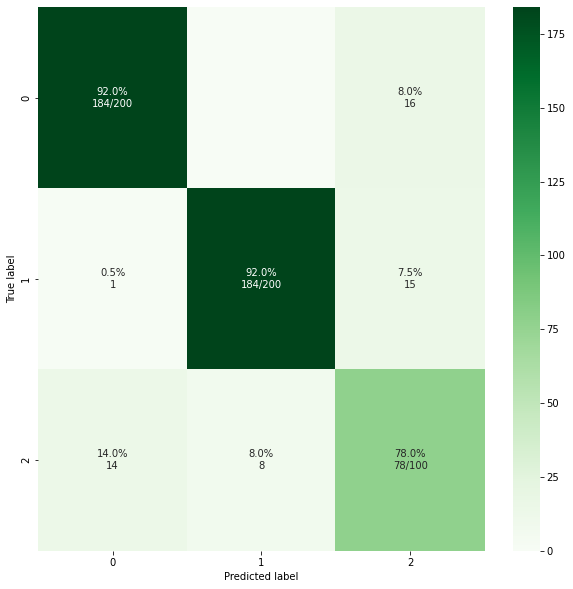

In [35]:
cm_analysis(y_test, y_pred, os.path.join(input_path, 'confusion_matrix_smote_gridsearch.png'),
            labels = None, ymap=None, figsize=(10,10))